In [ ]:
from google.colab import drive
drive.mount("/NML")

%cd ../NML/MyDrive/NML_Project

Mounted at /NML
/NML/MyDrive/NML_Project


In [ ]:
!pip install scikit-surprise nxviz

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 2.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 332.3/332.3 kB 9.9 MB/s eta 0:00:00
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.4-cp310-cp310-linux_x86_64.whl size=2357251 sha256=32fd9f17a1fdf4ed318d622eea6984871b33f5a26c3cb6a25d5b8d7da4bd41d4
  Stored in directory: /root/.cache/pip/wheels/4b/3f/df/6acbf0a40397d9bf3ff97f582cc22fb9ce66adde75bc71fd54
Successfully built scikit-surprise


In [ ]:
import numpy as np
import pandas as pd
import networkx as nx
from networkx.algorithms import bipartite
import matplotlib.pyplot as plt
from networkx.algorithms import components, distance_measures, cluster, bipartite
from community import community_louvain
# import powerlaw
from surprise import Reader, Dataset, SVD
from surprise.model_selection import cross_validate
import nxviz as nv
from scipy.stats import norm, kstest, expon
# import matplotlib.colors as mcolors
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error
from math import sqrt
# import similaripy as sim
from scipy.sparse import csr_matrix

In [ ]:
ratings = pd.read_csv( 'ratings.csv' )
to_read = pd.read_csv( 'to_read.csv' )
books = pd.read_csv( 'books.csv' )

tags = pd.read_csv( 'tags.csv' )
book_tags = pd.read_csv( 'book_tags.csv')

In [ ]:
ratings.head()

,user_id,book_id,rating
0,1,258,5
1,2,4081,4
2,2,260,5
3,2,9296,5
4,2,2318,3


In [ ]:
ratings.rating.mean()

3.9198655261735214

In [ ]:
n_ratings = len(ratings)
print('Number of ratings:', n_ratings)

Number of ratings: 5976479


In [ ]:
to_read.head()

,user_id,book_id
0,9,8
1,15,398
2,15,275
3,37,7173
4,34,380


In [ ]:
n_to_read = len(to_read)
print('Number of books to read:', n_to_read)

Number of books to read: 912705


In [ ]:
books.head()

,book_id,goodreads_book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,...,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url
0,1,2767052,2767052,2792775,272,439023483,9.780439e+12,Suzanne Collins,2008.0,The Hunger Games,...,4780653,4942365,155254,66715,127936,560092,1481305,2706317,https://images.gr-assets.com/books/1447303603m...,https://images.gr-assets.com/books/1447303603s...
1,2,3,3,4640799,491,439554934,9.780440e+12,"J.K. Rowling, Mary GrandPré",1997.0,Harry Potter and the Philosopher's Stone,...,4602479,4800065,75867,75504,101676,455024,1156318,3011543,https://images.gr-assets.com/books/1474154022m...,https://images.gr-assets.com/books/1474154022s...
2,3,41865,41865,3212258,226,316015849,9.780316e+12,Stephenie Meyer,2005.0,Twilight,...,3866839,3916824,95009,456191,436802,793319,875073,1355439,https://images.gr-assets.com/books/1361039443m...,https://images.gr-assets.com/books/1361039443s...
3,4,2657,2657,3275794,487,61120081,9.780061e+12,Harper Lee,1960.0,To Kill a Mockingbird,...,3198671,3340896,72586,60427,117415,446835,1001952,1714267,https://images.gr-assets.com/books/1361975680m...,https://images.gr-assets.com/books/1361975680s...
4,5,4671,4671,245494,1356,743273567,9.780743e+12,F. Scott Fitzgerald,1925.0,The Great Gatsby,...,2683664,2773745,51992,86236,197621,606158,936012,947718,https://images.gr-assets.com/books/1490528560m...,https://images.gr-assets.com/books/1490528560s...


In [ ]:
n_books = len(books)
print('Number of books:', n_books)

Number of books: 10000


In [ ]:
ratings.user_id.max()
print('Number of users:', ratings.user_id.max())

Number of users: 53424


In [ ]:
# Runtime: 1min
G = nx.Graph()

user_nodes = ratings['user_id'].unique()
book_nodes = ratings['book_id'].unique() + max(user_nodes)

max_user = max(user_nodes)

G.add_nodes_from(user_nodes, bipartite=0)
G.add_nodes_from(book_nodes, bipartite=1)

for row in ratings.itertuples(index=False):
    G.add_edge(row.user_id, max_user + int(row.book_id), weight=row.rating)

In [ ]:
if bipartite.is_bipartite(G):
    print("The graph is bipartite.")
else:
    print("The graph is not bipartite.")

print(G)

The graph is bipartite.
Graph with 63424 nodes and 5976479 edges


<Axes: >

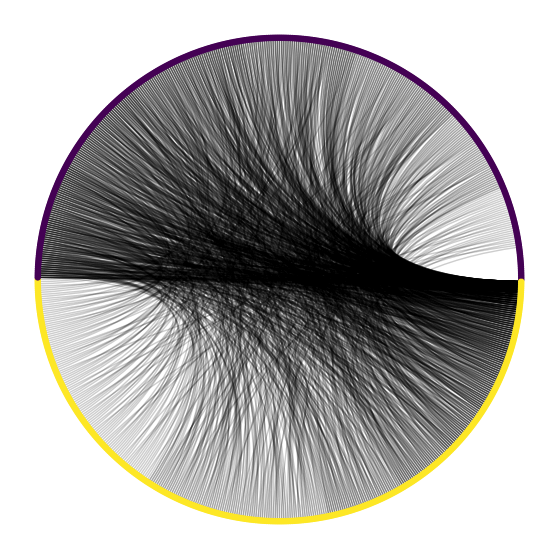

In [ ]:
n = 350
# Sample 5,000 user nodes
sampled_users = np.random.choice(user_nodes, n, replace=False)

sampled_books = set()
for user in sampled_users:
    sampled_books.update(G.neighbors(user))

# If the number of unique book nodes connected exceeds 5,000, randomly sample 5,000 from them
if len(sampled_books) > n:
    sampled_books = set(np.random.choice(list(sampled_books), n, replace=False))
else:
    # Increase the number of user nodes to ensure at least 5,000 book nodes are connected
    additional_users_needed = True
    while len(sampled_books) < n and additional_users_needed:
        additional_users = np.random.choice(
            list(set(user_nodes) - set(sampled_users)),
            min(n - len(sampled_books), len(set(user_nodes) - set(sampled_users))),
            replace=False
        )
        sampled_users = np.concatenate([sampled_users, additional_users])
        for user in additional_users:
            sampled_books.update(G.neighbors(user))
        additional_users_needed = len(set(user_nodes) - set(sampled_users)) > 0

    # If we still have less than 5,000 books, this means the graph simply does not have that many connections
    if len(sampled_books) > n:
        sampled_books = set(np.random.choice(list(sampled_books), n, replace=False))

# Create the induced subgraph
sampled_nodes = set(sampled_users).union(sampled_books)
subgraph = G.subgraph(sampled_nodes)


for n, d in subgraph.nodes(data=True):
    subgraph.nodes[n]["degree"] = subgraph.degree(n)

fig, ax = plt.subplots(figsize=(7, 7))
nv.circos(subgraph, sort_by="degree", group_by="bipartite", node_color_by="bipartite", node_enc_kwargs={"size_scale": 3})

In [ ]:
num_users = len(user_nodes)
num_books = len(book_nodes)

user_degrees = {node: val for node, val in G.degree() if node in user_nodes}
book_degrees = {node: val for node, val in G.degree() if node in book_nodes}

print('Number of users:', num_users)
print('Number of books:', num_books)
print('Number of edges:', G.number_of_edges())
print('Average degree:', sum(dict(G.degree()).values()) / G.number_of_nodes())

print('Average user degree:', sum(user_degrees.values()) / num_users)
print('Average book degree:', sum(book_degrees.values()) / num_books)

Number of users: 53424
Number of books: 10000
Number of edges: 5976479
Average degree: 188.46111881937438
Average user degree: 111.86880428271938
Average book degree: 597.6479


In [ ]:
# Top 3 active users based on the number of books rated
top_users = sorted(user_degrees.items(), key=lambda x: x[1], reverse=True)[:3]

# Top 3 books based on the number of ratings received
books_dict = pd.Series(books.title.values, index=books.book_id).to_dict()
top_books = sorted(book_degrees.items(), key=lambda x: x[1], reverse=True)[:3]
top_books = [(books_dict.get(x[0] - max_user, 'Unknown'), x[1]) for x in top_books]

print('Top 3 active users:', top_users)
print('Top 3 books:', top_books)

Top 3 active users: [(12874, 200), (30944, 200), (12381, 199)]
Top 3 books: [('The Hunger Games (The Hunger Games, #1)', 22806), ("Harry Potter and the Sorcerer's Stone (Harry Potter, #1)", 21850), ('To Kill a Mockingbird', 19088)]


**************************************************
Testing Book distribution (exp)
KS Statistic for Exponential: 0.20044741586968162
P-value for Exponential: 0.0
--------------------------------------------------
Testing User distribution (normal)
KS Statistic for Normal: 0.03445903781129256
P-value for Normal: 1.4998380606027288e-55
**************************************************


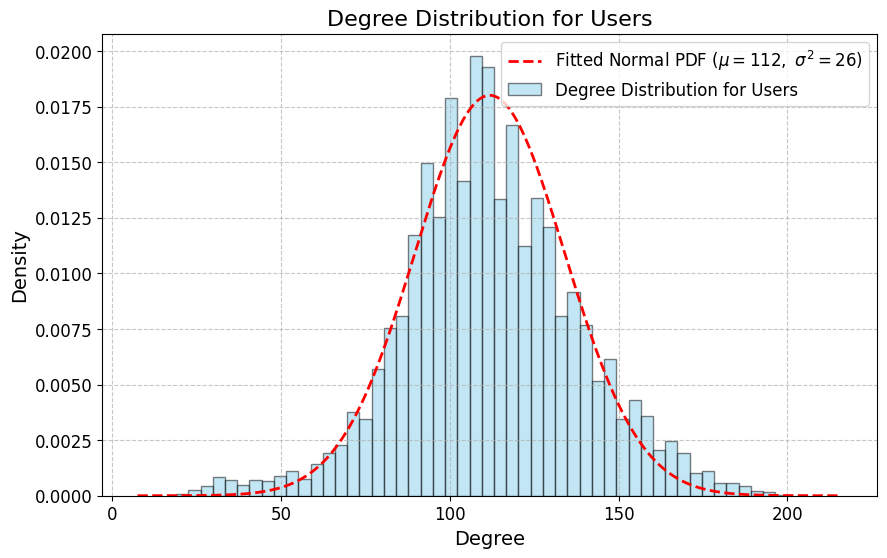

<ipython-input-65-522d2d35fc84>:57: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "r-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(x_item, pdf_fitted_exp, 'r-', lw=2, label=r'Fitted Exponential PDF ($\lambda = {:.3f}$)'.format(1/scale_exp), linestyle='--')


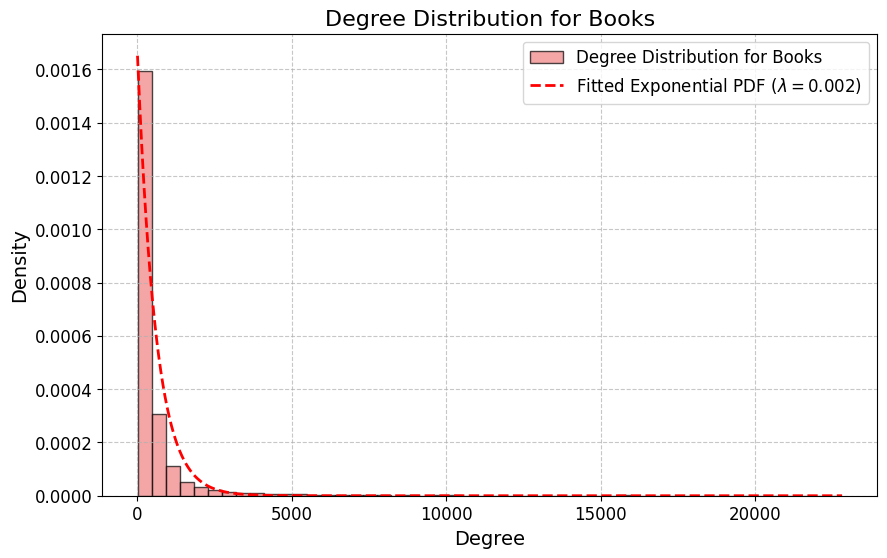

0.0016732259914240474


In [ ]:
node_ids = np.concatenate((user_nodes, book_nodes), axis=0)

# Calculate degrees
degrees = list(G.degree(node_ids))
user_degrees = [el[1] for el in degrees[:len(user_nodes)]]
item_degrees = [el[1] for el in degrees[len(user_nodes):]]

alpha = 0.05

# Fit an exponential distribution to the item degrees
loc_exp, scale_exp = expon.fit(item_degrees, floc=0)

# Perform the Kolmogorov-Smirnov test for exponential distribution
D_exp, p_value_exp = kstest(item_degrees, 'expon', args=(loc_exp, scale_exp))

# Print the results for the exponential test
print("*"*50)
print("Testing Book distribution (exp)")
print(f"KS Statistic for Exponential: {D_exp}")
print(f"P-value for Exponential: {p_value_exp}")
print("-"*50)

# Fit a normal distribution to the user degrees
mean_user, std_dev_user = norm.fit(user_degrees)

# Perform the Kolmogorov-Smirnov test for normal distribution
D_norm, p_value_norm = kstest(user_degrees, 'norm', args=(mean_user, std_dev_user))

# Print the results for the normal test
print("Testing User distribution (normal)")
print(f"KS Statistic for Normal: {D_norm}")
print(f"P-value for Normal: {p_value_norm}")
print("*"*50)


mean = np.mean(user_degrees)
std_dev = np.std(user_degrees)
x = np.linspace(mean - 4 * std_dev, mean + 4 * std_dev, 1000)
pdf_scaled = norm.pdf(x, loc=mean, scale=std_dev * 0.85)

plt.figure(figsize=(10, 6))
plt.plot(x, pdf_scaled, label=r'Fitted Normal PDF ($\mu = {:.0f},~\sigma^2 = {:.0f}$)'.format(mean, std_dev), color='red', linestyle='--', linewidth=2)
plt.hist(user_degrees, bins=bins, edgecolor='black', density=True, alpha=0.5, label='Degree Distribution for Users', color='skyblue')
plt.xlabel('Degree', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.title('Degree Distribution for Users', fontsize=16)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

plt.figure(figsize=(10, 6))
plt.hist(item_degrees, bins=bins, edgecolor='black', density=True, color='lightcoral', alpha=0.7, label='Degree Distribution for Books')
x_item = np.linspace(min(item_degrees), max(item_degrees), 1000)
pdf_fitted_exp = expon.pdf(x_item, loc=loc_exp, scale=scale_exp)
plt.plot(x_item, pdf_fitted_exp, 'r-', lw=2, label=r'Fitted Exponential PDF ($\lambda = {:.3f}$)'.format(1/scale_exp), linestyle='--')
plt.xlabel('Degree', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.title('Degree Distribution for Books', fontsize=16)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()
print(1/scale_exp)

<Figure size 1400x600 with 0 Axes>

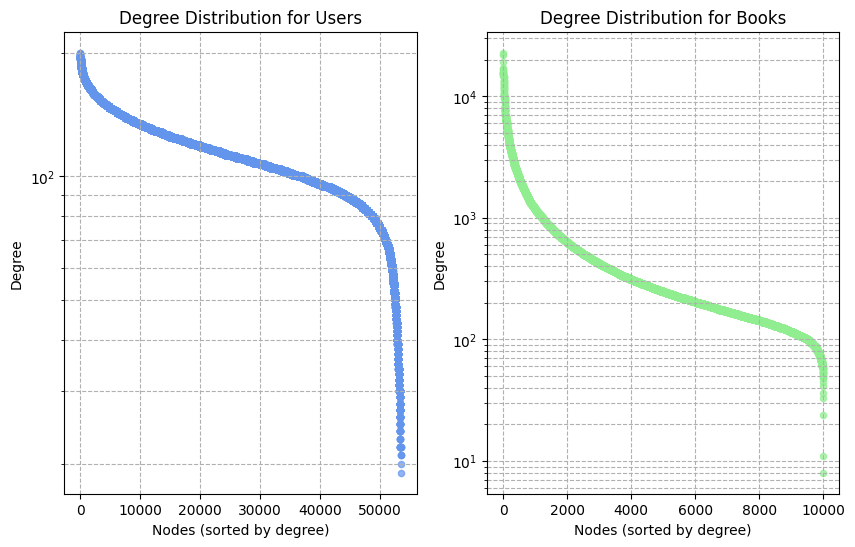

In [ ]:
# Extracting the degree for each user and book node
user_degrees = [deg for node, deg in G.degree() if node in user_nodes]
book_degrees = [deg for node, deg in G.degree() if node in book_nodes]

# user_fit = powerlaw.Fit(user_degrees)
# book_fit = powerlaw.Fit(book_degrees)

# Plotting the degree distribution for users
plt.figure(figsize=(14, 6))


# Creating the scatter plot of degrees
plt.figure(figsize=(10, 6))

plt.subplot(1, 2, 1)
plt.scatter(range(len(user_degrees)), sorted(user_degrees, reverse=True), c='cornflowerblue', alpha=0.7, s=20)
# user_fit.power_law.plot_pdf(color='r', linestyle='--', label='fit: a=%.2f, xmin=%.2f' % (user_fit.power_law.alpha, user_fit.power_law.xmin))
plt.title('Degree Distribution for Users')
plt.xlabel('Nodes (sorted by degree)')
plt.ylabel('Degree')
plt.yscale('log')
# plt.xscale('log')
plt.grid(True, which="both", ls="--")

# Creating the scatter plot of degrees
plt.subplot(1, 2, 2)
plt.scatter(range(len(book_degrees)), sorted(book_degrees, reverse=True), c='lightgreen', alpha=0.7, s=20)
# book_fit.power_law.plot_pdf(color='darkred', linestyle='--', label='fit: a=%.2f, xmin=%.2f' % (book_fit.power_law.alpha, book_fit.power_law.xmin))
plt.title('Degree Distribution for Books')
plt.xlabel('Nodes (sorted by degree)')
plt.ylabel('Degree')
plt.yscale('log')
# plt.xscale('log')
plt.grid(True, which="both", ls="--")

plt.show()

In [ ]:
# Parameters for the bipartite Erdős–Rényi graph
num_nodes_U = 53424  # Number of nodes in set U
num_nodes_V = 10000  # Number of nodes in set V
p = 0.01  # Probability of edge creation

# Generate a random bipartite graph
B = nx.bipartite.random_graph(num_nodes_U, num_nodes_V, p)

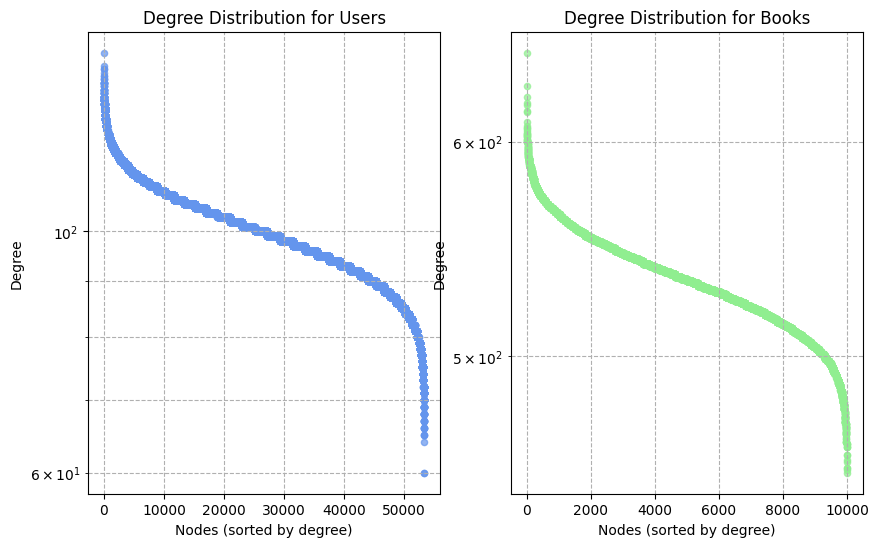

In [ ]:

# Extract degrees for both sets U and V
degrees_U = [d for n, d in B.degree() if n < num_nodes_U]
degrees_V = [d for n, d in B.degree() if n >= num_nodes_U]

plt.figure(figsize=(10, 6))

plt.subplot(1, 2, 1)
plt.scatter(range(len(degrees_U)), sorted(degrees_U, reverse=True), c='cornflowerblue', alpha=0.7, s=20)
plt.title('Degree Distribution for Users')
plt.xlabel('Nodes (sorted by degree)')
plt.ylabel('Degree')
plt.yscale('log')
# plt.xscale('log')
plt.grid(True, which="both", ls="--")

# Creating the scatter plot of degrees
plt.subplot(1, 2, 2)
plt.scatter(range(len(degrees_V)), sorted(degrees_V, reverse=True), c='lightgreen', alpha=0.7, s=20)
plt.title('Degree Distribution for Books')
plt.xlabel('Nodes (sorted by degree)')
plt.ylabel('Degree')
plt.yscale('log')
# plt.xscale('log')
plt.grid(True, which="both", ls="--")

plt.show()

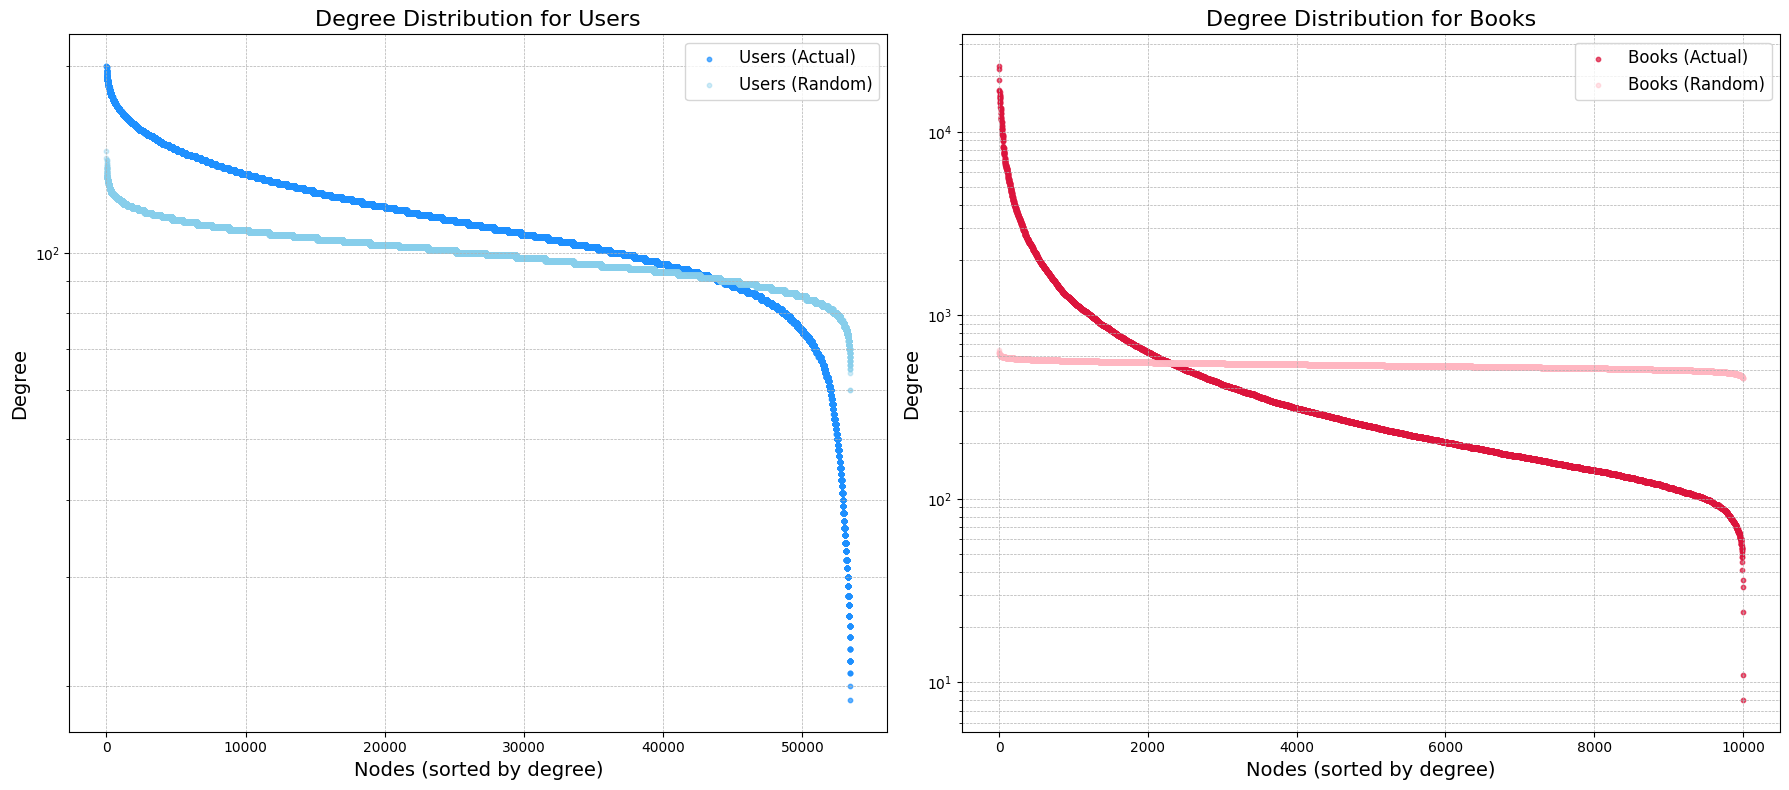

In [ ]:
# Extracting the degree for each user and book node
user_degrees = [deg for node, deg in G.degree() if node in user_nodes]
book_degrees = [deg for node, deg in G.degree() if node in book_nodes]

degrees_U = [d for n, d in B.degree() if n < num_nodes_U]
degrees_V = [d for n, d in B.degree() if n >= num_nodes_U]

# Plotting the degree distribution for users and books
plt.figure(figsize=(18, 8))

# Degree distribution for users
plt.subplot(1, 2, 1)
plt.scatter(range(len(user_degrees)), sorted(user_degrees, reverse=True),
            c='dodgerblue', alpha=0.7, s=10, label='Users (Actual)')
plt.scatter(range(len(degrees_U)), sorted(degrees_U, reverse=True),
            c='skyblue', alpha=0.4, s=10, label='Users (Random)')
plt.title('Degree Distribution for Users', fontsize=16)
plt.xlabel('Nodes (sorted by degree)', fontsize=14)
plt.ylabel('Degree', fontsize=14)
plt.yscale('log')
plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.legend(fontsize=12)

# Degree distribution for books
plt.subplot(1, 2, 2)
plt.scatter(range(len(book_degrees)), sorted(book_degrees, reverse=True),
            c='crimson', alpha=0.7, s=10, label='Books (Actual)')
plt.scatter(range(len(degrees_V)), sorted(degrees_V, reverse=True),
            c='lightpink', alpha=0.4, s=10, label='Books (Random)')
plt.title('Degree Distribution for Books', fontsize=16)
plt.xlabel('Nodes (sorted by degree)', fontsize=14)
plt.ylabel('Degree', fontsize=14)
plt.yscale('log')
plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.legend(fontsize=12)

plt.tight_layout()
plt.show()


For bipartite graphs, particularly those representing users and items (books in this case), the diameter can provide insight into the graph's connectivity and the potential reach of recommendations.

However, the interpretation is nuanced due to the structure of bipartite graphs:
1. **Alternate Nodes:** Paths in a bipartite graph alternate between the two sets of nodes. For a user-item graph, this means any path from one user to another (or one item to another) must go through items (or users). Thus, the diameter reflects the maximum number of alternating steps needed to connect any two nodes through their respective relationships.

2. **Connectivity:** A small diameter indicates a highly interconnected graph, suggesting that users are closely related through common items. This could imply a strong basis for collaborative filtering, as users' preferences might be closely aligned or overlapping.

3. **Recommendation Reach:** The concept of "six degrees of separation" in social networks could analogously apply here, indicating how recommendations might propagate through the network. A smaller diameter suggests that information (or influence) can quickly spread throughout the network.

4. **Isolation and Segments:** A large diameter could indicate isolated segments within the graph or long chains of relationships, potentially signaling diverse or niche interests among users or items.

In [ ]:
# # Since the graph might be disconnected, let's find the largest connected component first
# largest_cc = max(nx.connected_components(G), key=len)
# subgraph = G.subgraph(largest_cc)

# # Calculating various graph metrics
# metrics = {
#     "Number of Components": nx.number_connected_components(G),
#     "Diameter of Largest Component": distance_measures.diameter(subgraph),
#     "Average Shortest Path Length of Largest Component": nx.average_shortest_path_length(subgraph),
#     "Transitivity": cluster.transitivity(G),
#     "Average Clustering Coefficient": bipartite.average_clustering(G),
#     "Density": nx.density(G),
# }

# # Including node and edge counts for completeness
# metrics["Number of Nodes"] = G.number_of_nodes()
# metrics["Number of Edges"] = G.number_of_edges()

In [ ]:
# print(metrics)

In [ ]:
# # Result: 1
# nx.number_connected_components(G)
# print('Number of connected components:', nx.number_connected_components(G))

In [ ]:
# b = nx.average_shortest_path_length(G)
# print('Average shortest path length of largest component:', b)

In [ ]:
# c = bipartite.average_clustering(G)
# print('Average clustering coefficient:', c)

In [ ]:
# d = nx.density(G)
# print('Density:', d)

In [ ]:
# e = cluster.transitivity(G)
# print('Transitivity:', e)

In [ ]:

# a = distance_measures.diameter(G)
# print('Diameter of largest component:', a)

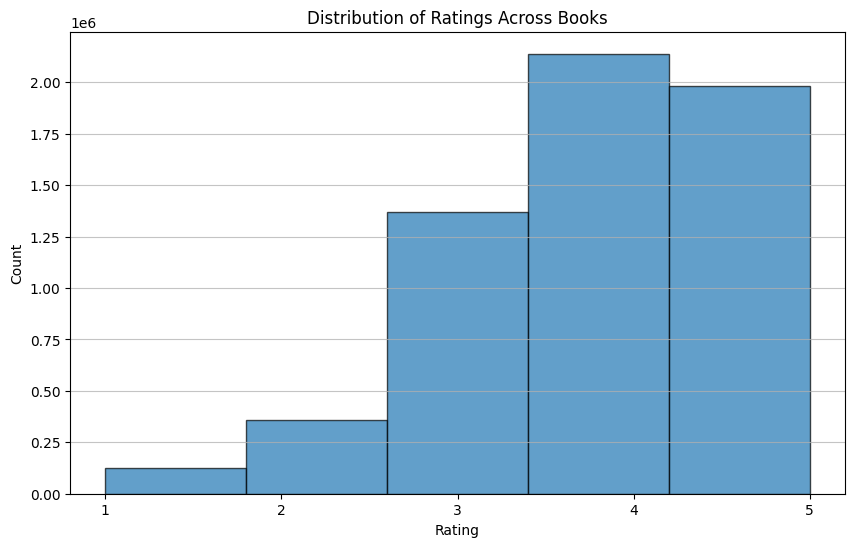

In [ ]:
# Generate a histogram of the distribution of ratings across books
plt.figure(figsize=(10, 6))
plt.hist(ratings['rating'], bins=5, edgecolor='black', alpha=0.7)
plt.title('Distribution of Ratings Across Books')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.xticks(range(1, 6))
plt.grid(axis='y', alpha=0.75)
plt.show()


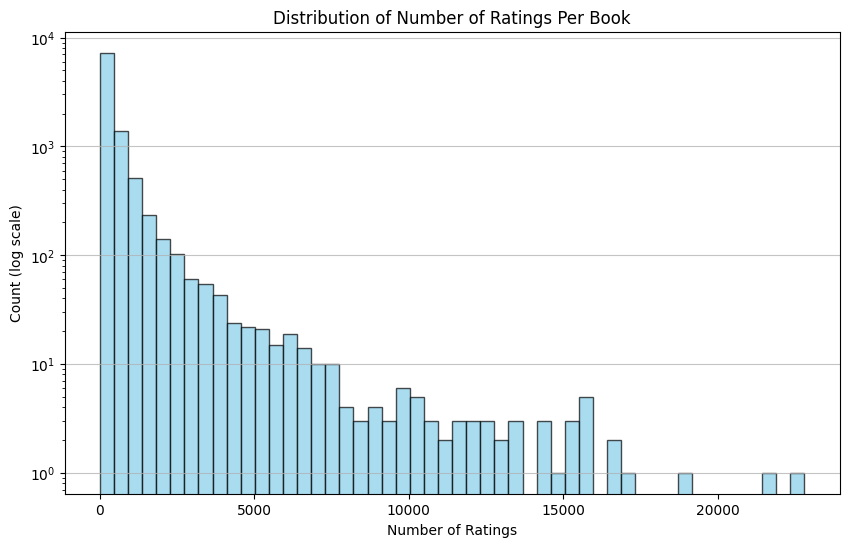

count    10000.000000
mean       597.647900
std       1267.289788
min          8.000000
25%        155.000000
50%        248.000000
75%        503.000000
max      22806.000000
dtype: float64

In [ ]:
# Calculate the number of ratings per book and visualize the distribution
ratings_per_book = ratings.groupby('book_id').size()

# Generate a histogram of the number of ratings per book
plt.figure(figsize=(10, 6))
plt.hist(ratings_per_book, bins=50, color='skyblue', edgecolor='black', alpha=0.7, log=True)
plt.title('Distribution of Number of Ratings Per Book')
plt.xlabel('Number of Ratings')
plt.ylabel('Count (log scale)')
plt.grid(axis='y', alpha=0.75)
plt.show()

ratings_per_book.describe()


$\rightarrow$ Books tend to have very few or no ratings however the amound of books without reviews is acceptable no need for prunning

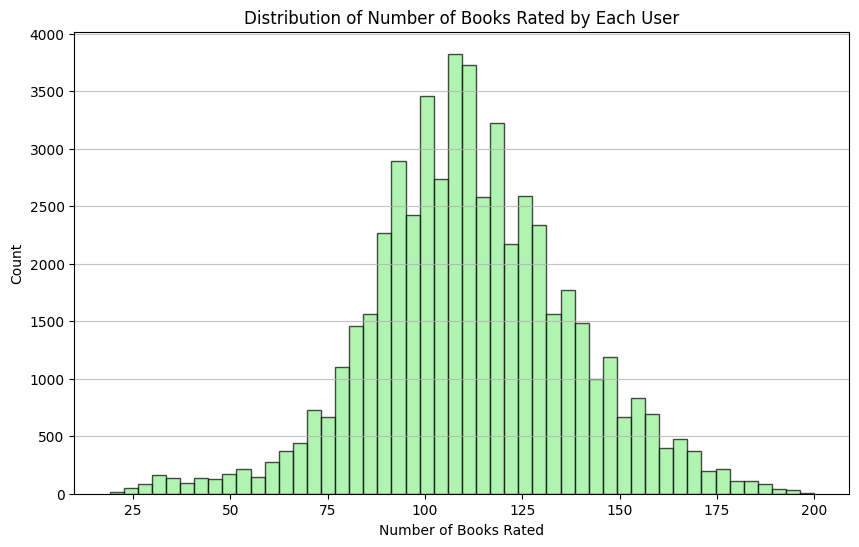

count    53424.000000
mean       111.868804
std         26.071224
min         19.000000
25%         96.000000
50%        111.000000
75%        128.000000
max        200.000000
dtype: float64

In [ ]:
# Calculate the number of books rated by each user and visualize the distribution
books_per_user = ratings.groupby('user_id').size()

# Generate a histogram of the number of books rated by each user
plt.figure(figsize=(10, 6))
plt.hist(books_per_user, bins=50, color='lightgreen', edgecolor='black', alpha=0.7)
plt.title('Distribution of Number of Books Rated by Each User')
plt.xlabel('Number of Books Rated')
plt.ylabel('Count')
plt.grid(axis='y', alpha=0.75)
plt.show()

books_per_user.describe()


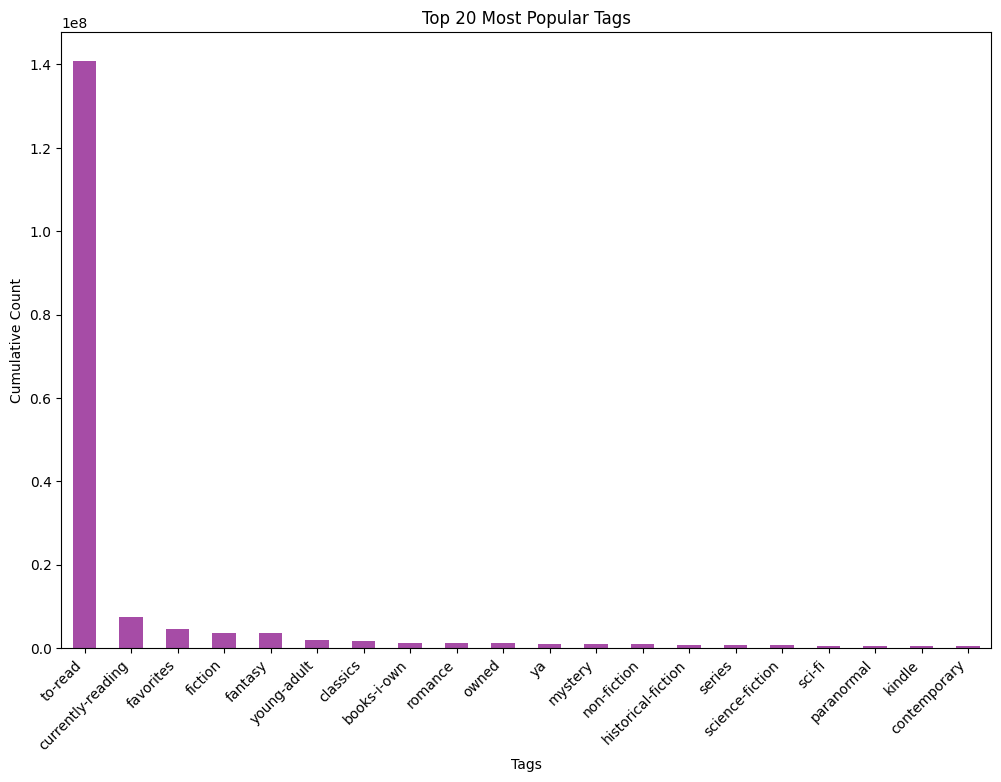

tag_name
to-read               140718761
currently-reading       7507958
favorites               4503173
fiction                 3688819
fantasy                 3548157
young-adult             1848306
classics                1756920
books-i-own             1317235
romance                 1231926
owned                   1224279
ya                       898334
mystery                  872282
non-fiction              857901
historical-fiction       815421
series                   782637
science-fiction          703866
sci-fi                   597325
paranormal               542559
kindle                   506882
contemporary             486001
Name: count, dtype: int64

In [ ]:
# Merge the book_tags with the tags data to get readable tag names
merged_tags = pd.merge(book_tags, tags, on='tag_id', how='left')

# Sum up the counts of each tag to see which are the most popular
tag_counts = merged_tags.groupby('tag_name')['count'].sum().sort_values(ascending=False).head(20)

# Plot the top 20 tags
plt.figure(figsize=(12, 8))
tag_counts.plot(kind='bar', color='purple', alpha=0.7)
plt.title('Top 20 Most Popular Tags')
plt.xlabel('Tags')
plt.ylabel('Cumulative Count')
plt.xticks(rotation=45, ha='right')
plt.show()

tag_counts


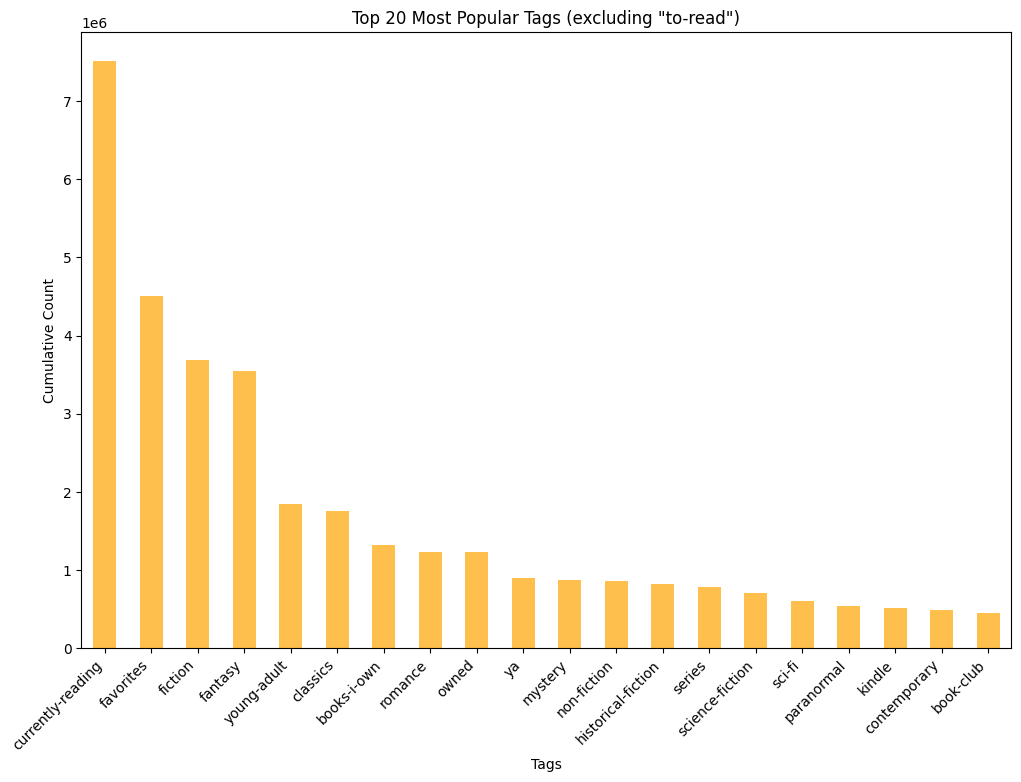

tag_name
currently-reading     7507958
favorites             4503173
fiction               3688819
fantasy               3548157
young-adult           1848306
classics              1756920
books-i-own           1317235
romance               1231926
owned                 1224279
ya                     898334
mystery                872282
non-fiction            857901
historical-fiction     815421
series                 782637
science-fiction        703866
sci-fi                 597325
paranormal             542559
kindle                 506882
contemporary           486001
book-club              446685
Name: count, dtype: int64

In [ ]:
# Filter out the "to-read" tag from the tags dataset
tags_filtered = tags[tags['tag_name'] != 'to-read']

# Merge the book_tags with the filtered tags data
merged_tags_filtered = pd.merge(book_tags, tags_filtered, on='tag_id', how='left')

# Sum up the counts of each tag to see which are the most popular, excluding "to-read"
tag_counts_filtered = merged_tags_filtered.groupby('tag_name')['count'].sum().sort_values(ascending=False).head(20)

# Plot the top 20 tags, excluding "to-read"
plt.figure(figsize=(12, 8))
tag_counts_filtered.plot(kind='bar', color='orange', alpha=0.7)
plt.title('Top 20 Most Popular Tags (excluding "to-read")')
plt.xlabel('Tags')
plt.ylabel('Cumulative Count')
plt.xticks(rotation=45, ha='right')
plt.show()

tag_counts_filtered


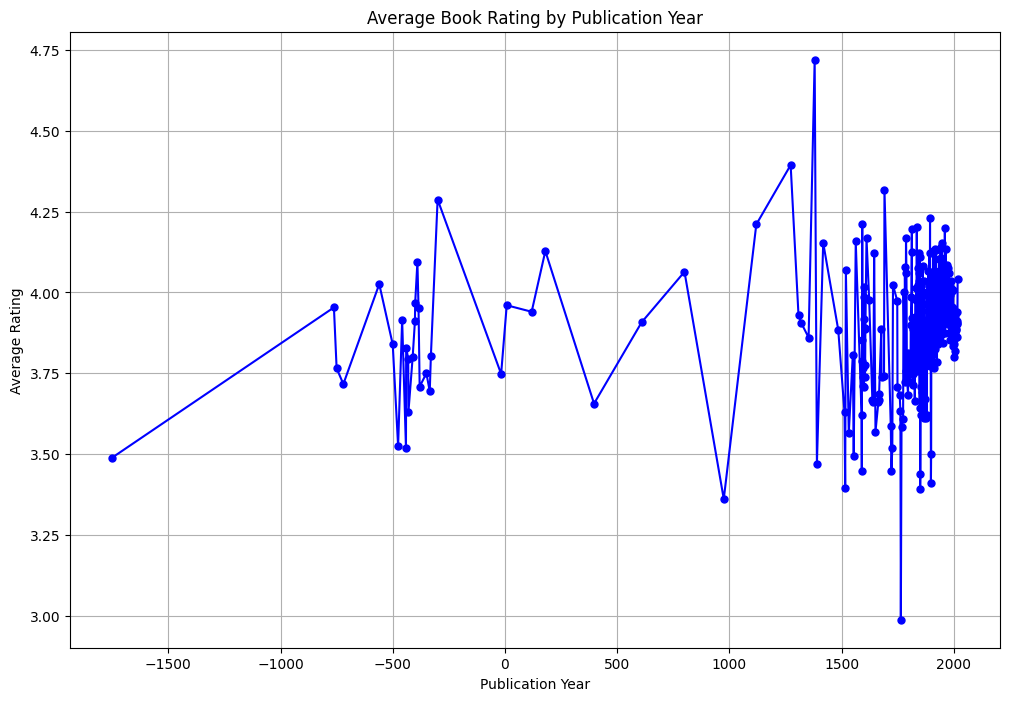

original_publication_year
2013.0    3.901480
2014.0    3.913035
2015.0    3.860927
2016.0    3.904331
2017.0    4.042921
Name: rating, dtype: float64

In [ ]:
# Merge ratings with books to include publication year
ratings_with_books = pd.merge(ratings, books[['book_id', 'original_publication_year']], on='book_id', how='left')

# Calculate average ratings per publication year
average_ratings_by_year = ratings_with_books.groupby('original_publication_year')['rating'].mean().dropna()

# Sorting the results to ensure the timeline is correct
average_ratings_by_year_sorted = average_ratings_by_year.sort_index()

# Plotting the average rating per publication year
plt.figure(figsize=(12, 8))
average_ratings_by_year_sorted.plot(kind='line', color='blue', marker='o', linestyle='-', markersize=5)
plt.title('Average Book Rating by Publication Year')
plt.xlabel('Publication Year')
plt.ylabel('Average Rating')
plt.grid(True)
plt.show()

average_ratings_by_year_sorted.tail()


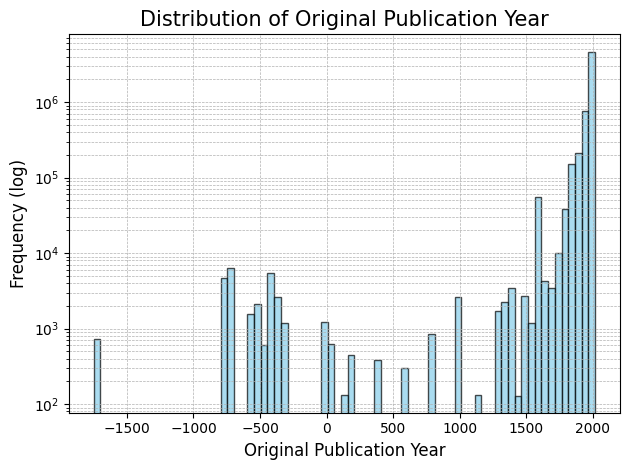

In [ ]:
ratings_with_books.hist(column='original_publication_year', bins=75, color='skyblue', edgecolor='black', alpha=0.7)

plt.yscale('log')
plt.xlabel('Original Publication Year', fontsize=12)
plt.ylabel('Frequency (log)', fontsize=12)
plt.title('Distribution of Original Publication Year', fontsize=15)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()

plt.show()

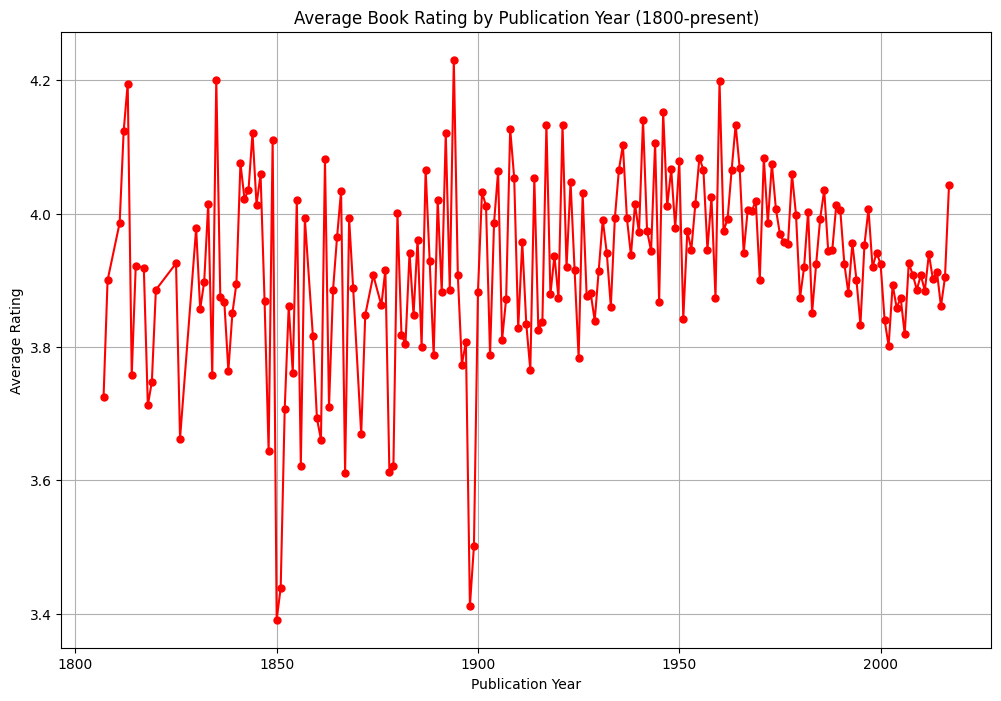

original_publication_year
2013.0    3.901480
2014.0    3.913035
2015.0    3.860927
2016.0    3.904331
2017.0    4.042921
Name: rating, dtype: float64

In [ ]:
# Filter ratings_with_books for publication years between 1500 and 2030
filtered_ratings_by_year = ratings_with_books[
    (ratings_with_books['original_publication_year'] >= 1800) &
    (ratings_with_books['original_publication_year'] <= 2030)
]

# Calculate average ratings per publication year within the filtered range
average_ratings_filtered = filtered_ratings_by_year.groupby('original_publication_year')['rating'].mean()

# Sorting the results to ensure the timeline is correct
average_ratings_filtered_sorted = average_ratings_filtered.sort_index()

# Plotting the average rating per publication year within the filtered range
plt.figure(figsize=(12, 8))
average_ratings_filtered_sorted.plot(kind='line', color='red', marker='o', linestyle='-', markersize=5)
plt.title('Average Book Rating by Publication Year (1800-present)')
plt.xlabel('Publication Year')
plt.ylabel('Average Rating')
plt.grid(True)
plt.show()

average_ratings_filtered_sorted.tail()


In [ ]:
books_pre_0 = books[books['original_publication_year'] < 0]
books_pre_0[['original_title', 'original_publication_year']].sort_values('original_publication_year')

,original_title,original_publication_year
2075,Shūtur eli sharrī,-1750.0
2141,Ἰλιάς ; Ὀδύσσεια,-762.0
340,Ἰλιάς,-750.0
6165,易 [Yì],-750.0
78,Ὀδύσσεια,-720.0
1119,Aesopica,-560.0
5636,धर्मपद [Dhammapada],-500.0
9678,उपनिषद [Upaniṣad],-500.0
402,孫子兵法 [Sūnzi bīngfǎ],-500.0
7777,論語 [Lún Yǔ],-476.0


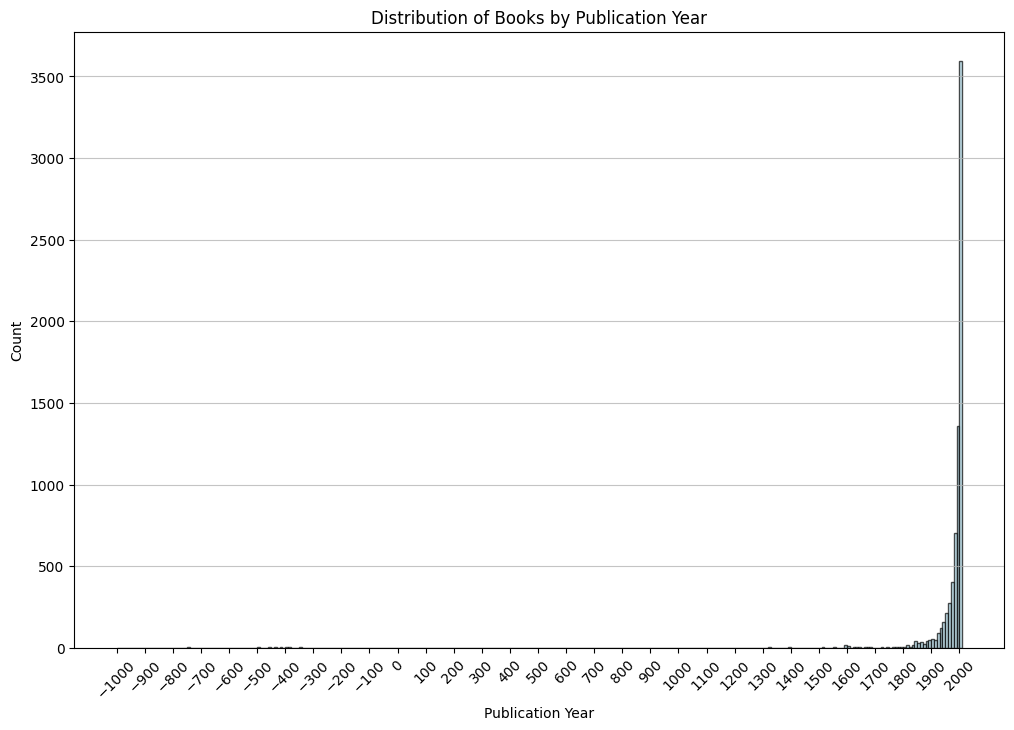

In [ ]:
# Distribution of books by publication year, dont show the labels of all years
plt.figure(figsize=(12, 8))
plt.hist(books['original_publication_year'], bins=range(-1000, 2020, 10), color='lightblue', edgecolor='black', alpha=0.7)
plt.title('Distribution of Books by Publication Year')
plt.xlabel('Publication Year')
plt.ylabel('Count')
plt.xticks(range(-1000, 2020, 100), rotation=45)
plt.grid(axis='y', alpha=0.75)
plt.show()


In [ ]:
# Runtime: ~13min

# Data Preparation: Setup the reader and the data
reader = Reader(rating_scale=(1, 5))  # Rating scale
data = Dataset.load_from_df(ratings[['user_id', 'book_id', 'rating']], reader)

# Model Setup: Use SVD algorithm
svd = SVD()

# Evaluation: Perform cross-validation
svd_results = cross_validate(svd, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

svd_results


Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8303  0.8298  0.8303  0.8312  0.8301  0.8303  0.0005  
MAE (testset)     0.6409  0.6403  0.6411  0.6412  0.6407  0.6409  0.0003  
Fit time          130.50  131.16  131.39  128.48  130.38  130.38  1.02    
Test time         47.79   36.70   34.65   40.37   35.11   38.92   4.87    


{'test_rmse': array([0.83030347, 0.82975562, 0.83034078, 0.83115004, 0.83014936]),
 'test_mae': array([0.64092552, 0.64031588, 0.64106577, 0.64122402, 0.64073458]),
 'fit_time': (130.49814248085022,
  131.15558576583862,
  131.38744401931763,
  128.47973728179932,
  130.38161540031433),
 'test_time': (47.79252219200134,
  36.69801473617554,
  34.65201663970947,
  40.37466788291931,
  35.10571575164795)}

**RMSE:** The mean RMSE across the 5 folds is 0.8305 with a very small standard deviation of 0.0005, indicating consistent performance across different subsets of the data.

**MAE:** The mean MAE is 0.6414, also with a small standard deviation (0.0003), reinforcing the model's consistent accuracy in different test sets.

In [ ]:
# Assume the SVD model is already trained and available as `svd`
# Assume `user_id` is set to the ID of the user for whom we want recommendations
user_id = 1  # example user ID

# Get the list of all books
all_books = books['book_id'].unique()

# Get the list of books that the user has already rated
rated_books = ratings[ratings['user_id'] == user_id]['book_id'].unique()

# Predict ratings for all books that the user hasn't rated yet
predictions = []
for book_id in set(all_books) - set(rated_books):
    predictions.append((book_id, svd.predict(user_id, book_id).est))

# Convert predictions to a DataFrame for easier handling
predictions_df = pd.DataFrame(predictions, columns=['book_id', 'predicted_rating'])

# Sort the predictions by the highest predicted ratings
top_recommendations = predictions_df.sort_values(by='predicted_rating', ascending=False).head(10)

# Optionally merge with the books dataset to get more details
recommended_books_details = pd.merge(top_recommendations, books[['book_id', 'title', 'authors']], on='book_id')

# Calculate the degree of the user
user_degree = ratings[ratings['user_id'] == user_id].shape[0]

print(f"The degree of user {user_id} is {user_degree}.")

# Display the top recommendations
recommended_books_details.head(10)

The degree of user 1 is 117.


,book_id,predicted_rating,title,authors
0,8946,4.906294,The Divan,Hafez
1,7947,4.795742,ESV Study Bible,"Anonymous, Lane T. Dennis, Wayne A. Grudem"
2,3628,4.696464,The Complete Calvin and Hobbes,Bill Watterson
3,1788,4.658582,The Calvin and Hobbes Tenth Anniversary Book,Bill Watterson
4,3753,4.647174,"Harry Potter Collection (Harry Potter, #1-6)",J.K. Rowling
5,4483,4.634764,It's a Magical World: A Calvin and Hobbes Coll...,Bill Watterson
6,6920,4.624179,The Indispensable Calvin and Hobbes,Bill Watterson
7,7254,4.613611,Homicidal Psycho Jungle Cat: A Calvin and Hobb...,Bill Watterson
8,8233,4.594100,The Book of Disquiet,"Fernando Pessoa, Richard Zenith"
9,6902,4.589833,Standing for Something: 10 Neglected Virtues T...,Gordon B. Hinckley


In [ ]:
from scipy.stats import pearsonr

# Assuming 'ratings' and 'books' DataFrames and the SVD model 'svd' are already loaded

# Predict ratings for a subset of users and books
user_ids = ratings['user_id'].unique()[:100]  # Sample of users for efficiency
predictions = {}

for user_id in user_ids:
    user_books = ratings[ratings['user_id'] != user_id]['book_id'].unique()[:100]  # Sample books not rated by the user
    high_rating_count = 0
    for book_id in user_books:
        predicted_rating = svd.predict(user_id, book_id).est
        if predicted_rating > 4:
            high_rating_count += 1
    predictions[user_id] = high_rating_count

# Calculate the degree for each user
user_degrees = ratings.groupby('user_id').size()

# Filter user degrees for users in the sample
sample_degrees = user_degrees[user_degrees.index.isin(user_ids)]

# Prepare data for correlation
confidences = [predictions[user_id] for user_id in user_ids]
degrees = [sample_degrees[user_id] for user_id in user_ids]

# Calculate Pearson correlation
correlation, _ = pearsonr(confidences, degrees)
print("Correlation coefficient:", correlation)

Correlation coefficient: 0.08829320446835218


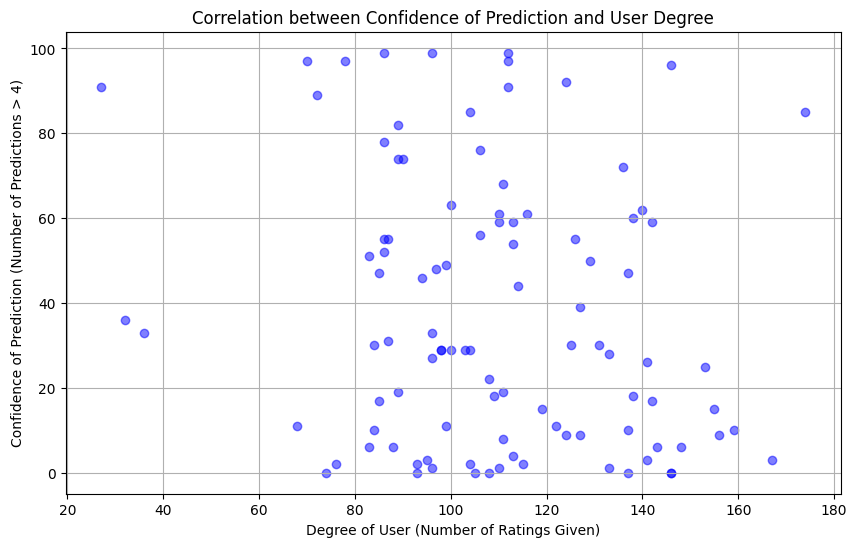

Pearson Correlation Coefficient: -0.19069351562494669


In [ ]:
import numpy as np

# Example data generation for plotting (using smaller numbers for demonstration)
np.random.seed(0)
sample_user_ids = np.random.choice(ratings['user_id'].unique(), size=100, replace=False)
confidences = []
degrees = []

for user_id in sample_user_ids:
    user_books = np.random.choice(books['book_id'].unique(), size=100, replace=False)
    high_rating_count = sum(svd.predict(user_id, book_id).est > 4 for book_id in user_books)
    confidences.append(high_rating_count)
    degree = ratings[ratings['user_id'] == user_id].shape[0]
    degrees.append(degree)

# Plotting the data
plt.figure(figsize=(10, 6))
plt.scatter(degrees, confidences, color='blue', alpha=0.5)
plt.title('Correlation between Confidence of Prediction and User Degree')
plt.xlabel('Degree of User (Number of Ratings Given)')
plt.ylabel('Confidence of Prediction (Number of Predictions > 4)')
plt.grid(True)
plt.show()

# Calculating the correlation
correlation_coefficient, _ = pearsonr(degrees, confidences)
print("Pearson Correlation Coefficient:", correlation_coefficient)

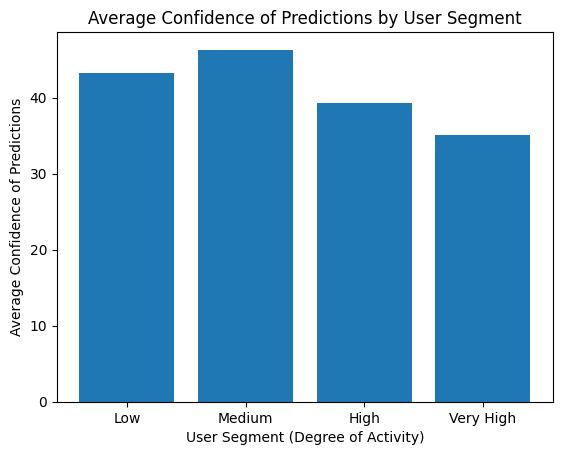

In [ ]:
# Divide users into segments based on the number of ratings
bins = [0, 50, 100, 150, np.inf]  # Define bins for user degree
labels = ['Low', 'Medium', 'High', 'Very High']
ratings['degree_bin'] = pd.cut(ratings['user_id'].map(ratings.groupby('user_id').size()), bins=bins, labels=labels)

# Calculate average confidence of predictions for each bin
confidence_by_segment = {}
for label in labels:
    user_ids = ratings[ratings['degree_bin'] == label]['user_id'].unique()
    total_confidence = 0
    total_users = len(user_ids)
    for user_id in user_ids:
        user_books = np.random.choice(books['book_id'].unique(), size=100, replace=False)
        high_rating_count = sum(svd.predict(user_id, book_id).est > 4 for book_id in user_books)
        total_confidence += high_rating_count
    average_confidence = total_confidence / total_users if total_users > 0 else 0
    confidence_by_segment[label] = average_confidence

# Plot the results
plt.bar(confidence_by_segment.keys(), confidence_by_segment.values())
plt.title('Average Confidence of Predictions by User Segment')
plt.xlabel('User Segment (Degree of Activity)')
plt.ylabel('Average Confidence of Predictions')
plt.show()

The bar chart illustrating the average confidence of predictions per user activity segment reveals a decreasing trend in prediction confidence as user activity increases. This pattern suggests several potential insights:

1. **Model Dynamics**: The recommendation model may be more effective for users with fewer interactions, potentially due to overfitting or increased noise in the data from users with more diverse or contradictory rating behaviors.

2. **Segment Variability**: Users with higher activity levels might engage with a wider array of books, leading to a naturally lower confidence in predictions due to diverse tastes or preferences that are harder to predict accurately.

3. **Strategic Implications**: Adjusting the model to better handle users with high activity or tailoring personalized recommendation strategies might improve performance. Additionally, analyzing the variance in ratings and the types of books rated by different segments could further elucidate the underlying reasons for this trend.

This analysis underscores the need for model adjustments to enhance prediction accuracy, particularly for very active users, and suggests a segmented approach to recommendation strategies based on user activity levels.

In [ ]:
# Compute user degrees (number of ratings per user)
user_degrees = ratings.groupby('user_id').size().sort_values(ascending=False).reset_index(name='num_ratings')

# Compute item popularity (number of ratings per book)
item_popularity = ratings.groupby('book_id').size().sort_values(ascending=False).reset_index(name='num_ratings')

# Compute item average rating
item_average_rating = ratings.groupby('book_id')['rating'].mean().sort_values(ascending=False).reset_index(name='average_rating')

# Compute top 10 influential users
top_users = ratings['user_id'].value_counts().head(10).reset_index(name='num_ratings')
top_users.columns = ['user_id', 'num_ratings']

# Compute top 10 popular books by count of ratings
top_books_by_count = ratings['book_id'].value_counts().head(10).reset_index(name='num_ratings')
# print(top_books_by_count)
popular_books_details_count = books[books['book_id'].isin(top_books_by_count['book_id'])][['book_id', 'title']]
popular_books_details_count = popular_books_details_count.merge(top_books_by_count, left_on='book_id', right_on='book_id')#.drop('index', axis=1)

# Compute top 10 books by average rating (considering books with at least 50 ratings)
book_ratings = ratings.groupby('book_id').agg(count=('rating', 'size'), average_rating=('rating', 'mean'))
top_books_by_rating = book_ratings[book_ratings['count'] > 50].sort_values(by='average_rating', ascending=False).head(10).reset_index()
popular_books_details_rating = books[books['book_id'].isin(top_books_by_rating['book_id'])][['book_id', 'title']]
popular_books_details_rating = popular_books_details_rating.merge(top_books_by_rating, on='book_id')

# Displaying the results
print("Top 10 Influential Users (User ID and Number of Ratings):\n", top_users)
print("\nTop 10 Popular Books by Count (Book ID, Title, and Number of Ratings):\n", popular_books_details_count)
print("\nTop 10 Books by Average Rating (Book ID, Title, Number of Ratings, and Average Rating):\n", popular_books_details_rating)

Top 10 Influential Users (User ID and Number of Ratings):
    user_id  num_ratings
0    12874          200
1    30944          200
2    52036          199
3    12381          199
4    28158          199
5    45554          197
6     6630          197
7    37834          196
8    15604          196
9     7563          196

Top 10 Popular Books by Count (Book ID, Title, and Number of Ratings):
    book_id                                              title  num_ratings
0        1            The Hunger Games (The Hunger Games, #1)        22806
1        2  Harry Potter and the Sorcerer's Stone (Harry P...        21850
2        3                            Twilight (Twilight, #1)        16931
3        4                              To Kill a Mockingbird        19088
4        5                                   The Great Gatsby        16604
5        7                                         The Hobbit        15558
6       17               Catching Fire (The Hunger Games, #2)        16549
7   

In [ ]:
item_popularity.head(10)

book_id
1     22806
2     21850
4     19088
3     16931
5     16604
17    16549
20    15953
18    15855
23    15657
7     15558
dtype: int64

In [ ]:
# Use a community detection algorithm like Louvain method
partitions = community_louvain.best_partition(G)

In [ ]:
# Analyzing the result
# To better understand the partitions, you might want to map back these partitions to users and books.
# Let's create a function to map partitions to node types (user/book):
def map_partitions(partitions, graph):
    community_by_type = {'user': {}, 'book': {}}
    user_nodes, book_nodes = bipartite.sets(graph)
    for node, community in partitions.items():
        if node in user_nodes:
            community_by_type['user'].setdefault(community, []).append(node)
        else:
            community_by_type['book'].setdefault(community, []).append(node)
    return community_by_type

# Map and print the partitions
community_by_type = map_partitions(partitions, G)
print(community_by_type)

{'user': {0: [1, 6, 9, 11, 15, 24, 28, 32, 40, 43, 49, 55, 61, 54, 56, 72, 75, 103, 108, 112, 123, 126, 128, 129, 143, 156, 164, 173, 174, 177, 178, 183, 187, 195, 199, 179, 10, 223, 229, 230, 237, 239, 240, 248, 250, 255, 256, 258, 162, 263, 265, 269, 101, 271, 278, 283, 279, 298, 311, 325, 323, 332, 345, 351, 362, 364, 360, 316, 375, 384, 385, 387, 388, 222, 394, 396, 400, 402, 403, 410, 416, 417, 427, 429, 439, 440, 423, 446, 447, 200, 452, 433, 468, 473, 480, 483, 487, 489, 367, 466, 503, 443, 448, 520, 533, 530, 547, 544, 550, 267, 558, 561, 566, 573, 574, 493, 582, 307, 592, 600, 608, 606, 605, 612, 615, 635, 637, 494, 650, 648, 654, 656, 84, 662, 675, 647, 684, 697, 669, 706, 725, 683, 695, 745, 748, 751, 752, 755, 759, 760, 769, 770, 701, 788, 797, 803, 807, 801, 811, 783, 392, 823, 857, 860, 863, 868, 875, 861, 881, 885, 899, 896, 892, 916, 668, 919, 921, 924, 943, 933, 972, 917, 975, 980, 983, 989, 1009, 1012, 1020, 1037, 1038, 667, 1043, 1063, 1065, 1061, 1084, 1091, 1103, 1

In [ ]:
from collections import defaultdict

# Count nodes in each community
community_sizes = defaultdict(int)
for node, community in partitions.items():
    community_sizes[community] += 1

# Output sizes of each community
for community, size in community_sizes.items():
    print(f"Community {community}: {size} nodes")


Community 0: 14228 nodes
Community 1: 15368 nodes
Community 2: 11304 nodes
Community 5: 868 nodes
Community 4: 5791 nodes
Community 3: 15865 nodes


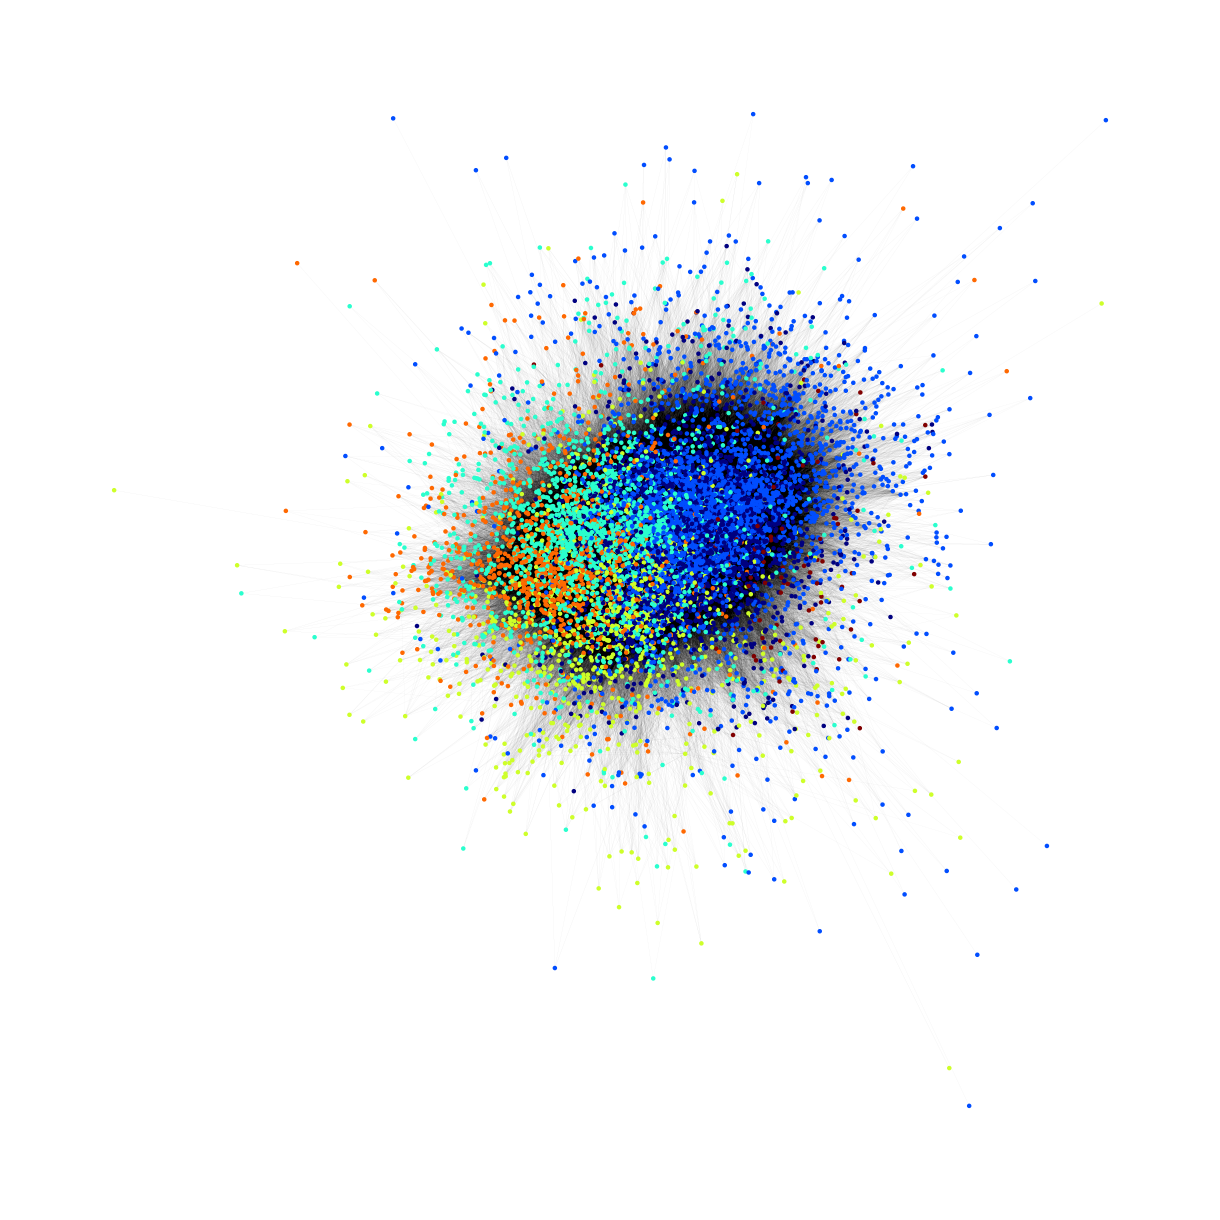

In [ ]:
# 5k books and 5k users: 8min
# Assuming 'partitions' is your dictionary from the Louvain method
user_communities = {node: com_id for node, com_id in partitions.items() if node in user_nodes}
book_communities = {node: com_id for node, com_id in partitions.items() if node in book_nodes}

# Create a subgraph for visualization purposes
subgraph_nodes = list(user_communities.keys())[:5000] + list(book_communities.keys())[:5000]
subgraph = G.subgraph(subgraph_nodes)

# Color nodes by their community
color_map = [partitions[node] for node in subgraph.nodes()]

# Draw the graph
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(subgraph, scale=2)
nx.draw(subgraph, pos, node_color=color_map, with_labels=False, node_size=5, cmap=plt.cm.jet, width=0.01)
plt.show()


In [ ]:
import plotly.graph_objects as go

edge_x = []
edge_y = []
for edge in subgraph.edges():
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    edge_x.append(x0)
    edge_x.append(x1)
    edge_x.append(None)
    edge_y.append(y0)
    edge_y.append(y1)
    edge_y.append(None)

edge_trace = go.Scatter(
    x=edge_x, y=edge_y,
    line=dict(width=0.5, color='#888'),
    hoverinfo='none',
    mode='lines')

node_x = []
node_y = []
for node in subgraph.nodes():
    x, y = pos[node]
    node_x.append(x)
    node_y.append(y)

node_trace = go.Scatter(
    x=node_x, y=node_y,
    mode='markers',
    hoverinfo='text',
    marker=dict(showscale=True, colorscale='Jet', size=10, color=color_map, colorbar=dict(thickness=15)))

node_trace.text = [str(node) for node in subgraph.nodes()]
fig = go.Figure(data=[edge_trace, node_trace],
             layout=go.Layout(
                showlegend=False,
                hovermode='closest',
                margin=dict(b=0,l=0,r=0,t=0),
                xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                yaxis=dict(showgrid=False, zeroline=False, showticklabels=False))
                )
fig.show()


In [ ]:
!pip install similaripy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 335.1/335.1 kB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for similaripy: filename=similaripy-0.1.3-cp310-cp310-linux_x86_64.whl size=2403249 sha256=6a03537aabb7aab0dccd24279cc69c358f18ede3e96e1586c4ae14cc96e4be65
  Stored in directory: /root/.cache/pip/wheels/d6/33/27/e6c171b89bc13ac3d669433d0de550244a800c720383ff35ae
Successfully built similaripy


In [ ]:
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors

# Create User-Item Matrix
ratings_books_cleaned = ratings.dropna()
user_item_matrix = ratings_books_cleaned.pivot(index='user_id', columns='book_id', values='rating').fillna(0)

# Convert to sparse matrix format
sparse_user_item = csr_matrix(user_item_matrix)

# Fit Nearest Neighbors model
model = NearestNeighbors(metric='cosine', algorithm='brute')
model.fit(sparse_user_item)

# Function to recommend books for a given user_id
def recommend_books(user_id, n_recommendations=5):
    user_index = user_item_matrix.index.get_loc(user_id)
    distances, indices = model.kneighbors(user_item_matrix.iloc[user_index, :].values.reshape(1, -1), n_neighbors=n_recommendations + 1)

    recommendations = []
    for i in range(1, len(distances.flatten())):
        book_id = user_item_matrix.columns[indices.flatten()[i]]
        recommendations.append((book_id, distances.flatten()[i]))

    return recommendations

# Example: Recommend books for user_id 4
recommendations = recommend_books(4)
recommendations

In [ ]:
# Ensure reproducibility
np.random.seed(42)
ratings_books_cleaned = ratings.dropna()

# Randomly sample 5,000 unique books and 5,000 unique users
# sampled_books = ratings_books_cleaned['book_id'].dropna().unique()
# sampled_users = ratings_books_cleaned['user_id'].dropna().unique()

sampled_ratings = ratings_books_cleaned.sample(n=50, replace=False)

# if len(sampled_books) > 5000:
#     sampled_books = np.random.choice(sampled_books, 5000, replace=False)
# if len(sampled_users) > 5000:
#     sampled_users = np.random.choice(sampled_users, 5000, replace=False)

# Filter the ratings_books_cleaned dataframe to include only the sampled books and users
# sampled_ratings = ratings_books_cleaned[ratings_books_cleaned['book_id'].isin(sampled_books) & ratings_books_cleaned['user_id'].isin(sampled_users)]

# Create the user-item matrix from the sampled data
user_item_matrix_sampled = sampled_ratings.pivot(index='user_id', columns='book_id', values='rating').fillna(0)


# Convert to sparse matrix format
sparse_user_item_sampled = csr_matrix(user_item_matrix_sampled)

# Normalize matrix with bm25
sui_sampled = sim.normalization.bm25(sparse_user_item_sampled)

# Train the model with 50 knn per item
model_sampled = sim.cosine(sui_sampled.T, k=50)


# Recommend 100 items to users 1, 14, and 8 filtering the items already seen by each user
user_recommendations_sampled = sim.dot_product(sui_sampled, model_sampled.T, k=20, target_rows=[1], filter_cols=sui_sampled)

user_recommendations_sampled


Done: 100%|██████████| 1/1 [00:00<00:00, 66.20it/s]


<50x48 sparse matrix of type '<class 'numpy.float32'>'
	with 20 stored elements in COOrdinate format>

In [ ]:
# Convert to dense format if needed
user_recommendations_dense = user_recommendations_sampled.toarray()

print(user_recommendations_dense)
for i in range(user_recommendations_dense.shape[0]):
  for j in range(user_recommendations_dense.shape[1]):
    if user_recommendations_dense[i,j] != 0:
      print(user_recommendations_dense[i,j])

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
5.9649243


In [ ]:
rows, cols = user_recommendations_sampled.nonzero()
values = user_recommendations_sampled.data

# Print the non-zero entries
for row, col, value in zip(rows, cols, values):
    print(f"({row}, {col}): {value}")

(1, 20): 5.964924335479736


In [ ]:
from google.colab import drive
drive.mount("/NML")

%cd ../NML/MyDrive/NML_Project

Drive already mounted at /NML; to attempt to forcibly remount, call drive.mount("/NML", force_remount=True).
[Errno 2] No such file or directory: '../NML/MyDrive/NML_Project'
/NML/MyDrive/NML_Project


In [ ]:
import pandas as pd
pd.set_option('display.max_columns', None)

ratings = pd.read_csv( 'ratings.csv' )
books = pd.read_csv( 'books.csv' )
recommendations = pd.read_json('recommendations.jsonl', lines=True)

recommendation_list = []

# Iterate over each column (user_id) and gather the book ids
for column in recommendations.columns:
    for book_ids in recommendations[column].dropna():
        for book_id in book_ids:
            recommendation_list.append((int(column), book_id))

# Convert the list to a DataFrame
recommendations = pd.DataFrame(recommendation_list, columns=['user_id', 'book_id'])

In [ ]:
english_codes = ['eng', 'en-US', 'en-GB', 'en-CA', 'en']
books['language_code'] = books['language_code'].apply(lambda x: 'eng' if x in english_codes else x)

books_filt = books.drop(columns=[
    'goodreads_book_id', 'best_book_id', 'isbn', 'isbn13', 'image_url', 'small_image_url',
    'original_title', 'title', 'ratings_1', 'ratings_2',	'ratings_3',	'ratings_4', 'ratings_5',
    'authors'
  ])
books_filt = books_filt.dropna()
# author_counts = books_filt['authors'].value_counts()

# # Find the top 100 authors
# top_authors = author_counts.nlargest(500).index

# # Replace authors not in the top 100 with 'Other'
# books_filt['authors'] = books_filt['authors'].apply(lambda x: x if x in top_authors else 'Other')

In [ ]:
# books_filt['authors'].value_counts()#[:10].plot.bar()

In [ ]:
recommendation_book_info = recommendations.merge(books_filt, on='book_id', how='left')
ratings_book_info = ratings.merge(books_filt, on='book_id', how='left')

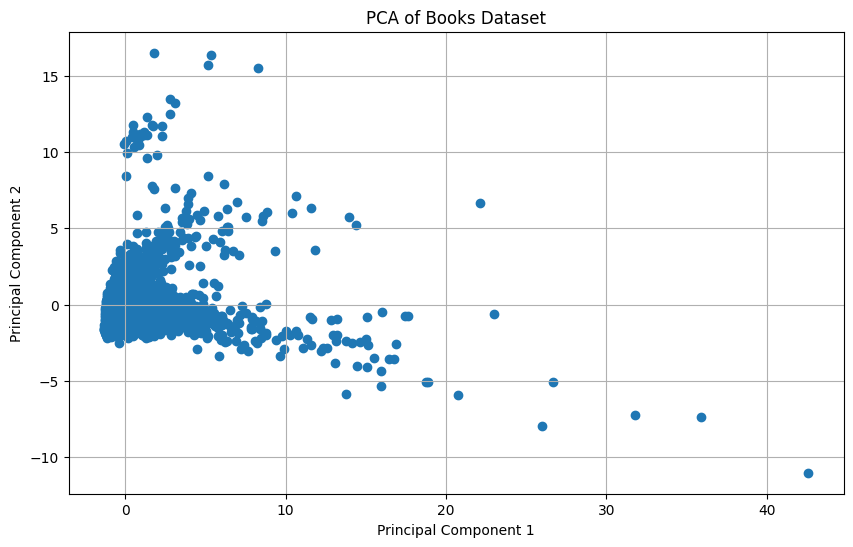

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt

numeric_features = books_filt.select_dtypes(include=['number']).columns.tolist()
categorical_features = books_filt.select_dtypes(include=['object']).columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

pca = PCA(n_components=2)

pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('pca', pca)])

principal_components = pipeline.fit_transform(books_filt)

principal_df = pd.DataFrame(data=principal_components, columns=['principal component 1', 'principal component 2'])

plt.figure(figsize=(10, 6))
plt.scatter(principal_df['principal component 1'], principal_df['principal component 2'])
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of Books Dataset')
plt.grid(True)
plt.show()

In [ ]:
ratings_book_info.head()

,user_id,book_id,rating,work_id,books_count,original_publication_year,average_rating,ratings_count,work_ratings_count,work_text_reviews_count,language_code_ara,language_code_dan,language_code_eng,language_code_fil,language_code_fre,language_code_ger,language_code_ind,language_code_ita,language_code_jpn,language_code_mul,language_code_nl,language_code_nor,language_code_per,language_code_pol,language_code_por,language_code_rum,language_code_rus,language_code_spa,language_code_swe,language_code_tur,language_code_vie
0,1,258,5,3209783,279,2001.0,4.24,263685,317554,24652,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,2,4081,4,1005335,53,2004.0,3.40,19293,21580,1891,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,2,260,5,2370171,353,1936.0,4.13,282623,305437,7909,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,2,9296,5,821815,75,1979.0,4.09,9563,10830,537,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,2,2318,3,5210,43,1995.0,4.00,43937,46748,2049,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
